In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Load

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', data_dir = '/content/drive/MyDrive/GD-CV/GD_02/data',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    download=False
)

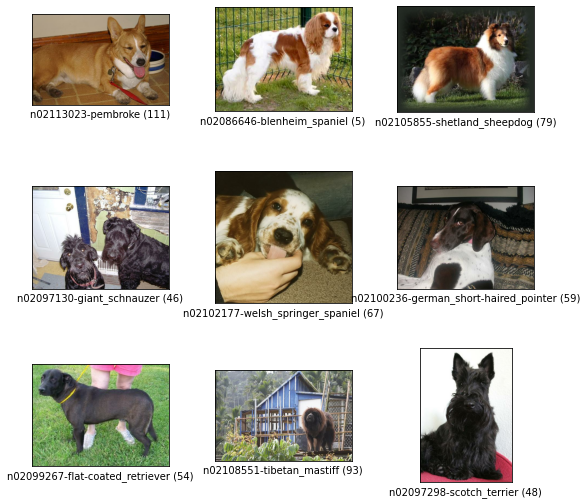

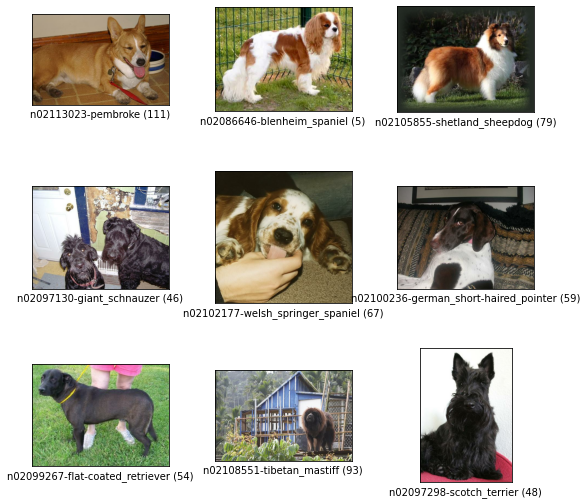

In [6]:
tfds.show_examples(ds_train, ds_info)

# Data pre-preocessing

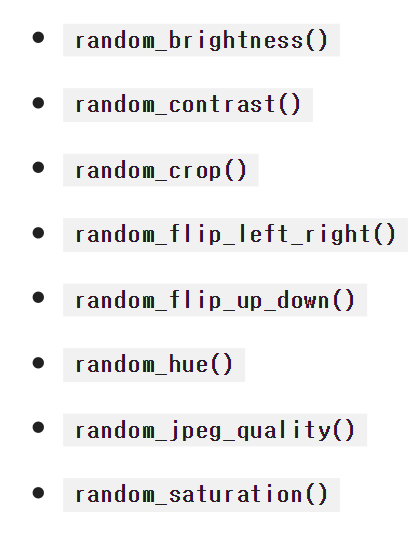

# Auqmentation 함수 생성

In [7]:
#이미지 전처리
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [8]:
# make random augment function
def augment(image,label):
    
    # left_right
    image = tf.image.random_flip_left_right(image,seed=4242)

    # crop
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])

    # cotrast
    image = tf.image.random_contrast(image, 0.7, 1.3, seed=4242)
    
    # flip_left    
    image = tf.image.random_flip_left_right(image, seed=4242)
    
    # flip_up_down
    image = tf.image.random_flip_up_down(image, seed=4242)
    
    # saturation
    image = tf.image.random_saturation(image,0.6, 1.6,seed = 4242)
    
    # noise
    image = tf.image.random_jpeg_quality(image, 75, 95,seed=4242)
    
    # hue
    image = tf.image.random_hue(image,0.08,seed=4242)

    image = tf.image.random_brightness(image, max_delta=125, seed =4242)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [14]:
num_classes = ds_info.features["label"].num_classes
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = '/content/drive/MyDrive/GD-CV/GD_02/data',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    download=False
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# CutMix

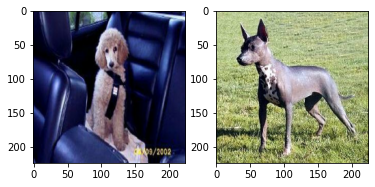

In [15]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [16]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(9, shape=(), dtype=int32) tf.Tensor(115, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(91, shape=(), dtype=int32)


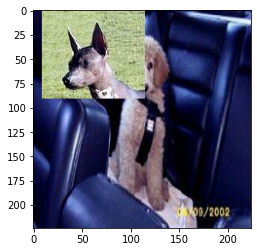

In [17]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [18]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

## CutMix 로 이미지를 생성하고 label까지 지정해주는 함수 생성

In [19]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# MixUp

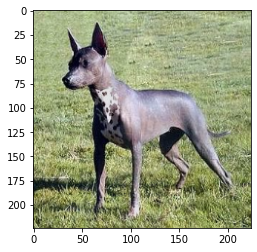

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [20]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

## MixUp 및 Label까지 지정해주는 함수 생성

In [21]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    # mixed_img, label 생성
    return mixed_imgs, mixed_labels

------------

In [22]:
#데이터 셋  가공
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup =False):
    # 데이터 셋의 이미지를 노멀라이징
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # map함수를  사용하여 데이터셋을 함수에 적용시킨 상태로 출력하는 원리
    
    if not is_test and with_aug:# training & aug적용 할 경우, augmetation 적용해서 데이터셋을 변형 (배치 미적용 상태)
        ds = ds.map(
            augment
        )
    # augmentation 적용 안 한 배치로 반환
    """
    CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
    """
    
    ds = ds.batch(batch_size) # 데이터셋을 배치로 나눔

    # training 이고 cutmix적용할 경우
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # trainging 이고 mix_up적용하는 경우
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls =  2
        )
    else:
    # test인경우 or augmentation을 하지 않는 경우, 원-핫 인코딩으로 이미지와 라벨을 정함  
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    #

    #테스트가  아닌경우 > 배치를 shuffle
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Model 생성

총 6가지 case

>case1. augmentation 미적용

>case2. augmentation만 적용

>case3. cutmix 적용

>case4. mixup 적용
<!-- 
>case5. augmetation and cutmix 적용

>case6. augmetation and mixuo 적용 -->

In [24]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [25]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
cut_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# aug_and_mix_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
# aug_and_cut_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

### 모델 학습할 데이터셋 분리

In [28]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',data_dir = '/content/drive/MyDrive/GD-CV/GD_02/data',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
#1
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
#2
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
#3
ds_train_cut = apply_normalize_on_dataset(ds_train, with_cutmix = True)
#4
ds_train_mix = apply_normalize_on_dataset(ds_train, with_mixup =True)

#5
# ds_train_aug_and_cut = apply_normalize_on_dataset(ds_train, with_aug=True,with_cutmix = True )
#6
# ds_train_aug_and_mix = apply_normalize_on_dataset(ds_train, with_aug=True,with_cutmix = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 모델학습

In [30]:
EPOCH = 20

In [33]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 114s 137ms/step - loss: 2.2008 - accuracy: 0.4467 - val_loss: 3.4805 - val_accuracy: 0.1897
Epoch 2/20
750/750 [==============================] - 97s 129ms/step - loss: 0.7464 - accuracy: 0.7898 - val_loss: 1.1999 - val_accuracy: 0.6514
Epoch 3/20
750/750 [==============================] - 97s 129ms/step - loss: 0.2510 - accuracy: 0.9460 - val_loss: 0.9402 - val_accuracy: 0.7263
Epoch 4/20
750/750 [==============================] - 97s 129ms/step - loss: 0.0652 - accuracy: 0.9935 - val_loss: 0.9093 - val_accuracy: 0.7378
Epoch 5/20
750/750 [==============================] - 98s 131ms/step - loss: 0.0227 - accuracy: 0.9994 - val_loss: 0.9080 - val_accuracy: 0.7394
Epoch 6/20
750/750 [==============================] - 97s 130ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.9182 - val_accuracy: 0.7406
Epoch 7/20
750/750 [==============================] - 97s 130ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.9395 - val_accuracy: 0.

In [34]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 130s 146ms/step - loss: 4.8532 - accuracy: 0.0069 - val_loss: 4.8111 - val_accuracy: 0.0092
Epoch 2/20
750/750 [==============================] - 109s 145ms/step - loss: 4.8046 - accuracy: 0.0075 - val_loss: 4.8219 - val_accuracy: 0.0069
Epoch 3/20
750/750 [==============================] - 110s 146ms/step - loss: 4.7998 - accuracy: 0.0071 - val_loss: 4.8031 - val_accuracy: 0.0091
Epoch 4/20
750/750 [==============================] - 112s 150ms/step - loss: 4.7963 - accuracy: 0.0070 - val_loss: 4.7978 - val_accuracy: 0.0114
Epoch 5/20
750/750 [==============================] - 112s 149ms/step - loss: 4.7951 - accuracy: 0.0070 - val_loss: 4.8066 - val_accuracy: 0.0069
Epoch 6/20
750/750 [==============================] - 129s 173ms/step - loss: 4.7935 - accuracy: 0.0072 - val_loss: 4.7938 - val_accuracy: 0.0087
Epoch 7/20
750/750 [==============================] - 115s 154ms/step - loss: 4.7930 - accuracy: 0.0069 - val_loss: 4.7929 - val_accura

In [31]:
cut_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cut = cut_resnet50.fit(
    ds_train_cut, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 127s 136ms/step - loss: 3.8288 - accuracy: 0.2107 - val_loss: 3.2982 - val_accuracy: 0.2267
Epoch 2/20
750/750 [==============================] - 99s 132ms/step - loss: 2.9461 - accuracy: 0.4353 - val_loss: 1.6366 - val_accuracy: 0.5518
Epoch 3/20
750/750 [==============================] - 99s 132ms/step - loss: 2.6452 - accuracy: 0.5262 - val_loss: 1.2808 - val_accuracy: 0.6428
Epoch 4/20
750/750 [==============================] - 99s 132ms/step - loss: 2.4268 - accuracy: 0.6003 - val_loss: 1.2468 - val_accuracy: 0.6643
Epoch 5/20
750/750 [==============================] - 99s 132ms/step - loss: 2.2786 - accuracy: 0.6426 - val_loss: 1.2696 - val_accuracy: 0.6592
Epoch 6/20
750/750 [==============================] - 98s 131ms/step - loss: 2.1579 - accuracy: 0.6833 - val_loss: 1.1751 - val_accuracy: 0.6796
Epoch 7/20
750/750 [==============================] - 98s 131ms/step - loss: 2.1138 - accuracy: 0.6985 - val_loss: 1.2649 - val_accuracy: 0.

In [32]:
mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mix = mix_resnet50.fit(
    ds_train_mix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 111s 132ms/step - loss: 3.7171 - accuracy: 0.2366 - val_loss: 3.9711 - val_accuracy: 0.1334
Epoch 2/20
750/750 [==============================] - 98s 131ms/step - loss: 2.8649 - accuracy: 0.4692 - val_loss: 1.6936 - val_accuracy: 0.5279
Epoch 3/20
750/750 [==============================] - 98s 130ms/step - loss: 2.5941 - accuracy: 0.5879 - val_loss: 1.2894 - val_accuracy: 0.6319
Epoch 4/20
750/750 [==============================] - 98s 131ms/step - loss: 2.3798 - accuracy: 0.6600 - val_loss: 1.2882 - val_accuracy: 0.6444
Epoch 5/20
750/750 [==============================] - 98s 131ms/step - loss: 2.2391 - accuracy: 0.7103 - val_loss: 1.2397 - val_accuracy: 0.6589
Epoch 6/20
750/750 [==============================] - 98s 131ms/step - loss: 2.1333 - accuracy: 0.7506 - val_loss: 1.1986 - val_accuracy: 0.6713
Epoch 7/20
750/750 [==============================] - 98s 131ms/step - loss: 2.0744 - accuracy: 0.7769 - val_loss: 1.2671 - val_accuracy: 0.

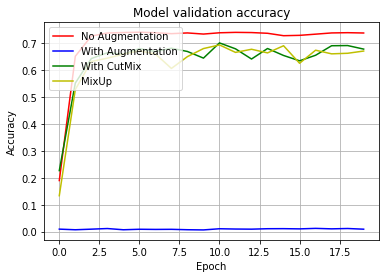

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cut.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mix.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix','MixUp'], loc='upper left')
plt.grid(True)
plt.show()

# 회고 

데이터 셋에 각각 Augmentation, CutMix, Mixup을 적용 했을 때, 20 Epoch 에서는 어떤 조치도 하지 않을 때가 가장 Validation Accuracy가 높았다.\
\
이 때문에 과연 Dataset에 다양한 기법들을 적용시키는 것이 도움이 되는지 의문이 들었다.\
\
왜냐하면 Augmentation을 제외하면 Validation Acc가 일정 수치에서 수렴한 뒤 진동하는 경향을 보였기 때문에 20 Epoch은 충분한 학습횟수라 생각한다.

\
특이할 만한 점으로는 Augmentation을 "과하게 했을 때"의 결과인데 TensorFlow API에서 제공하는 Augmentation 메서드를 

대부분 다 적용시켰을 때의 결과는 Val_Accuracy = 0%에 수렴하는 결과를 낳았다.

이에 Augmentation을 적게 적용시켰을 때의 결과를 찾아 보니 Augmentation을 적게 적용시켰을 때 결과는 

아무 조치도 취하지 않을 때와 같거나 조금 더 높은 결과를 보였던 것으로 기억한다.\
\
\
그렇다면 Augmentation은 그 자체의 성능에 대해 평가를 하는 것이 아닌 Data Set이 부족한 상황에서 그만큼의 순정 데이터셋을 모은 것과 같은 효과를 주는지 평가하는 것이 더 적합할것 같다는 생각이 들었다.